# An example of Perceptron
## Environment

In [1]:
%load_ext watermark
%watermark -a "Ziyi Xi" -u -d -p numpy,pandas,matplotlib

Ziyi Xi 
last updated: 2019-01-21 

numpy 1.15.1
pandas 0.23.4
matplotlib 2.2.3


The code below is adapted from the Book "Python machine learning". The flags I have added:
+ use_adaptive_stepsize=False

## using adaptive step size 
The perceptron learning rule: $\Delta w_j=\eta (y^{(i)}-y^{(i)}_p)$

Here $\Delta w_j$ is the weight to update, $\eta$ is the learning rate, $y^{(i)}$ is the true class label of the ith class label, $y^{(i)}_p$ is the predicted class label.

The more data mislabeled, it seems the bigger $\eta$ should be. So here in each step, I choose $\eta$ as:
$$\eta=2\eta_0 \frac{n_{mis}}{n_{all}}$$

Here $\eta$ is the learning rate for each step, $\eta_0$ is the initial learning rate, $n_{mis}$ is the number of data mislabeled, $n_{all}$ is the total number of data points. The $2$ means the expection of the data mislocated rate is 0.5, using $2$ could be coincide with the case not using adaptive stepsize.

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from IPython.display import HTML
%matplotlib inline

## The code of Perceptron

In [268]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    use_adaptive_stepsize : bool
      If use the algorithm of adaptive step size. 
    scale: float
      The scale in np.random.random.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1,use_adaptive_stepsize=False,scale=0.01):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.use_adaptive_stepsize=use_adaptive_stepsize
        self.n_all=0
        self.scale=scale
        
        # return to plot
        self.initplot={}
        self.toplot=[]
        

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        self.n_all=np.shape(X)[0]
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=self.scale, size=1 + X.shape[1])
        self.errors_ = []
        
        # plot initdata
        self.initplot={
                    "plotted_data_X":X,
                    "plotted_data_y":y,
        }

        for _ in range(self.n_iter):
            errors = 0
            eta_updated=self.update_eta()
            for index,(xi, target) in enumerate(zip(X, y)):
                update = eta_updated * (target - self.predict(xi))
                
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
                
                self.toplot.append({
                    "index":index,
                    "m":-self.w_[1]/self.w_[2],
                    "b":-self.w_[0]/self.w_[2],
                    "step":_
                })
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)
    
    def update_eta(self):
        """update eta based on the algorithm described above"""
        if(self.use_adaptive_stepsize):
            try:
                n_mis=self.errors_[-1]
            except:
                n_mis=self.n_all
            n_all=self.n_all
            return self.eta*(n_mis/n_all)
        else:
            return self.eta

# Generate Data
The data generated below is adapted from Prof. M.

In [298]:
def generate_data(num,m,b,eps,random_state=5,use_shuffle=True):
    """y=m*x+b"""
    rgen = np.random.RandomState(random_state)
    x1_ones = rgen.random_sample(num)
    x1_zeros = rgen.random_sample(num)
    x_line = np.linspace(0,1)
    
    x2_ones = m*x1_ones + b + rgen.random_sample(x1_ones.size) + eps
    x2_zeros = m*x1_zeros + b - rgen.random_sample(x1_zeros.size) - eps
    y_line = m*x_line + b 
    
    plt.figure(figsize=(14,7))
    plt.plot(x_line,y_line,'--',label='answer')
    plt.plot(x1_ones,x2_ones,'bo', label='ones')
    plt.plot(x1_zeros,x2_zeros,'g+', label='minus ones')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("data points")
    plt.legend()
    plt.plot()
    
    X=np.zeros((2*num,2))
    y=np.zeros(2*num)
    for i in range(num):
        X[i]=np.array([x1_ones[i],x2_ones[i]])
        y[i]=1
        X[i+num]=np.array([x1_zeros[i],x2_zeros[i]])
        y[i+num]=-1
        
    if(use_shuffle):
        shuffle=np.arange(2*num)
        rgen = np.random.RandomState(92)
        rgen.shuffle(shuffle)
        X=X[shuffle,:]
        y=y[shuffle]
    return X,y

## Animation

In [299]:
# The function to animate
class SubplotAnimation(animation.TimedAnimation):
    def __init__(self,initplot,toplot,realm,realb):
        self.initplot=initplot
        self.toplot=toplot
        self.realm=realm
        self.realb=realb
        
        fig = plt.figure(figsize=(21,14))
        ax1 = fig.add_subplot(1, 1, 1)
        self.ax1=ax1

        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        
        self.line1 = Line2D([], [],linestyle="--",color="k")
        self.line1bg= Line2D([], [], linestyle="--",color="y")
        self.line1pos = Line2D([], [], marker="o",linewidth=0,color="b",markersize=6)
        self.line1neg = Line2D(
            [], [], marker="+",linewidth=0,color="g",markersize=6)
        self.line1default=Line2D(np.linspace(0,1),realm*np.linspace(0,1)+realb,color="r")
        
        ax1.add_line(self.line1)
        ax1.add_line(self.line1bg)
        ax1.add_line(self.line1pos)
        ax1.add_line(self.line1neg)
        ax1.add_line(self.line1default)
        
        ax1.set_xlim(-0.25, 1.25)
        ax1.set_ylim(-10, 10)
        ax1.legend((self.line1, self.line1bg,self.line1pos,self.line1neg,self.line1default), ('updating line', 'line in the last iter', 'points with label 1','points with label -1','real line'), loc='upper right', shadow=True)

        animation.TimedAnimation.__init__(self, fig, interval=200, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        head = self.toplot[i]["index"]
        self.ax1.set_title("iterations: "+str(int(i/20))+", used points # of this iteration: "+str(head))
        
        x1_line = np.linspace(0,1)
        m=self.toplot[i]["m"]
        b=self.toplot[i]["b"]
        x2_line=m*x1_line+b
        self.line1.set_data(x1_line,x2_line)
        
        x1_bg=np.linspace(0,1)
        if(i>=20):
            m=self.toplot[20*int(i/20)]["m"]
            b=self.toplot[20*int(i/20)]["b"]
        else:
            m=self.realm
            b=self.realb

        x2_bg=m*x1_bg+b
        self.line1bg.set_data(x1_bg,x2_bg)
        
        x1_plotted=self.initplot["plotted_data_X"][:head,0]
        x2_plotted=self.initplot["plotted_data_X"][:head,1]
        y_plotted=self.initplot["plotted_data_y"][:head]
        
        x1_pos=np.array([x1_plotted[i] for i in range(np.shape(x1_plotted)[0]) if y_plotted[i]==1])
        x2_pos=np.array([x2_plotted[i] for i in range(np.shape(x2_plotted)[0]) if y_plotted[i]==1])
        self.line1pos.set_data(x1_pos,x2_pos)
        
        x1_neg=np.array([x1_plotted[i] for i in range(np.shape(x1_plotted)[0]) if y_plotted[i]==-1])
        x2_neg=np.array([x2_plotted[i] for i in range(np.shape(x2_plotted)[0]) if y_plotted[i]==-1])        
        self.line1neg.set_data(x1_neg,x2_neg)

        self._drawn_artists = [self.line1, self.line1bg ,self.line1pos, self.line1neg]

    def new_frame_seq(self):
        return iter(range(np.shape(self.toplot)[0]))

    def _init_draw(self):
        x1_pos=np.array([X[i] for i in range(np.shape(X)[0]) if y[i]==1])
        x2_pos=np.array([X[i] for i in range(np.shape(X)[0]) if y[i]==1])
        self.line1pos.set_data(x1_pos,x2_pos)
        
        x1_neg=np.array([X[i] for i in range(np.shape(X)[0]) if y[i]==-1])
        x2_neg=np.array([X[i] for i in range(np.shape(X)[0]) if y[i]==-1])        
        self.line1neg.set_data(x1_neg,x2_neg) 
        
        self.line1.set_data([],[])
        self.line1bg.set_data([],[])

## Put them into a function
Below is the main part of the code, the parameters are:
+ eta: learning rate
+ n_iter: number of iterations
+ use_adaptive_stepsize: if use adaptive step size
+ scale: define the sparsity of the initial value of weight.

In [303]:
def main(eta=0.01,n_iter=5,use_adaptive_stepsize=False,scale=0.01,number_of_data_points=20,m=2.5,b=0,weight_seed=88,data_seed=72,use_shuffle=True):
    per=Perceptron(eta=eta,n_iter=n_iter,use_adaptive_stepsize=use_adaptive_stepsize,scale=scale,random_state=weight_seed)
    
    X,y=generate_data(int(number_of_data_points/2),m,b,0.1,data_seed,use_shuffle=use_shuffle)
    per.fit(X,y)
    
    plotx=np.arange(n_iter)+1
    ploty=per.errors_
    plt.figure(figsize=(14,7))
    plt.plot(plotx,ploty,"--")
    plt.xlabel("step")
    plt.ylabel("# data mislabeled")
    plt.title("error figure")
    plt.show()
    
    return per,m,b

# Execute the main function

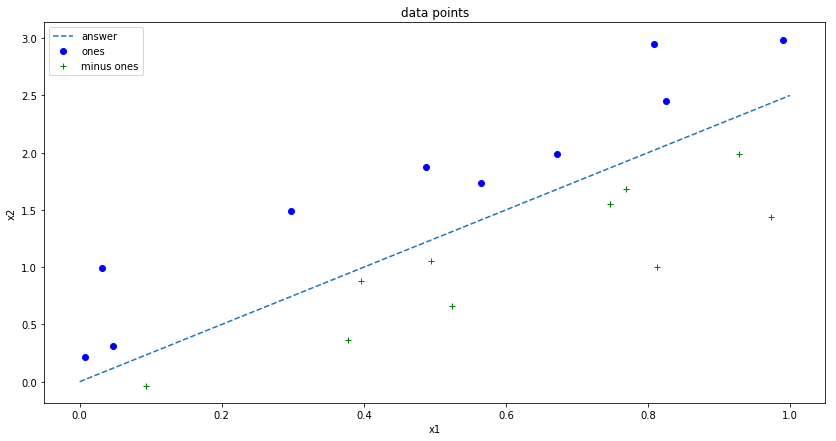

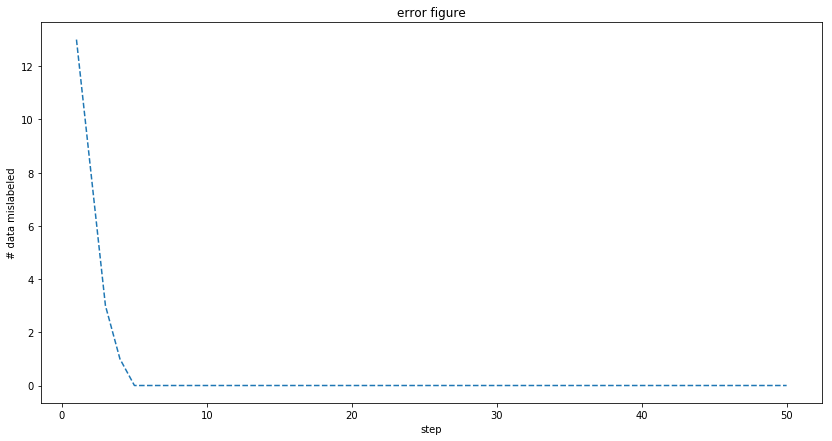

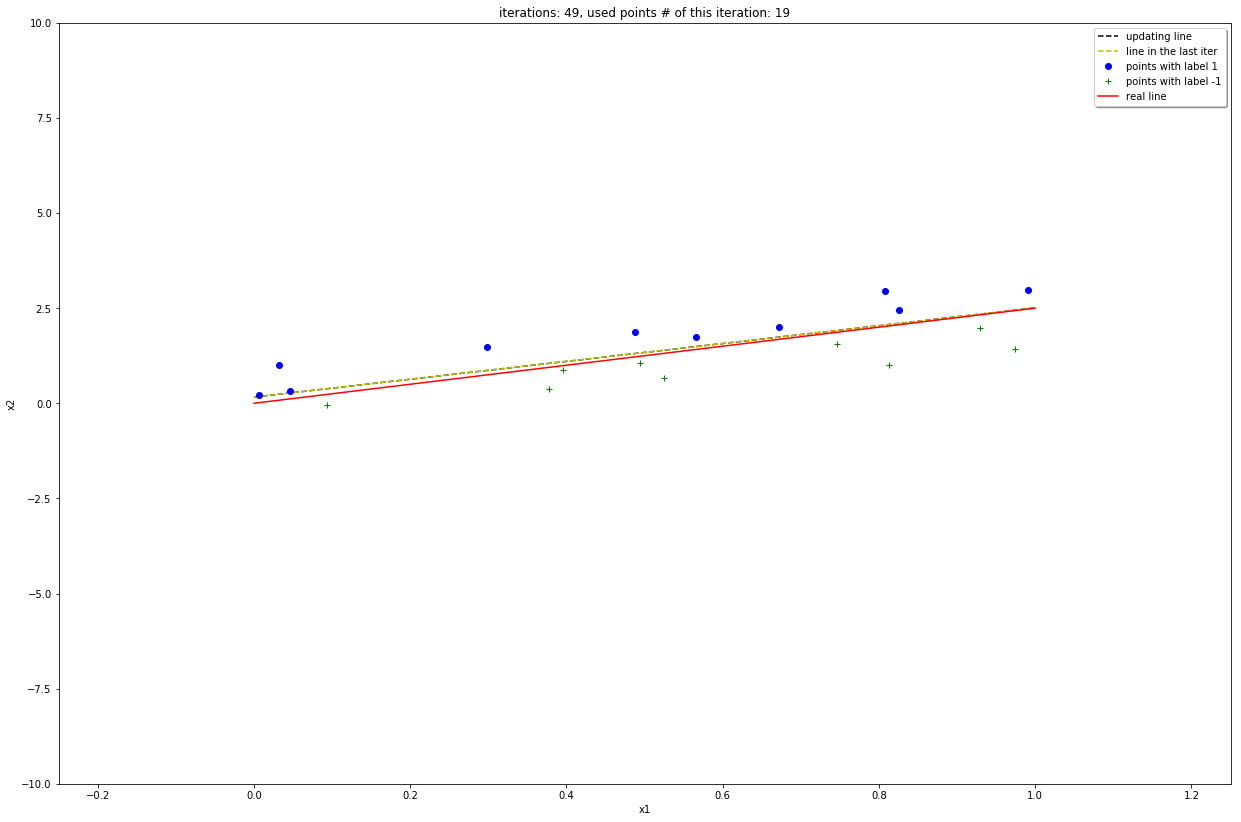

In [301]:
per,m,b=main(eta=0.005,n_iter=50,weight_seed=56,data_seed=99,use_adaptive_stepsize=True,number_of_data_points=20)
ani = SubplotAnimation(per.initplot,per.toplot,m,b)
# ani.save('/tmp/test_sub.mp4')
HTML(ani.to_html5_video())

## Using the adaptive step size & not using

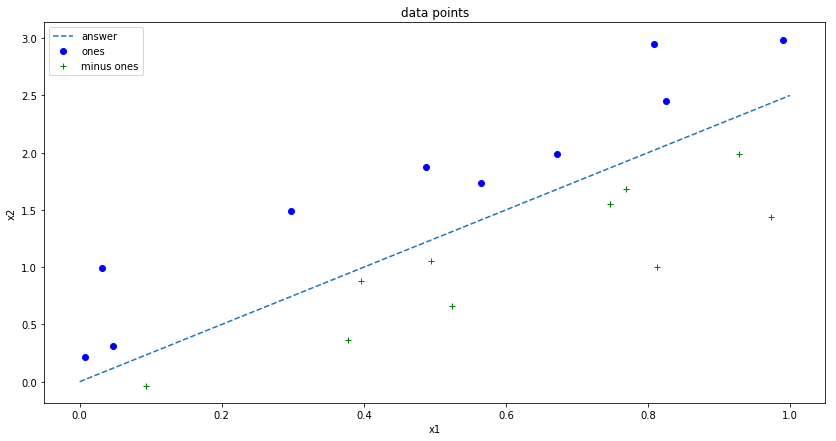

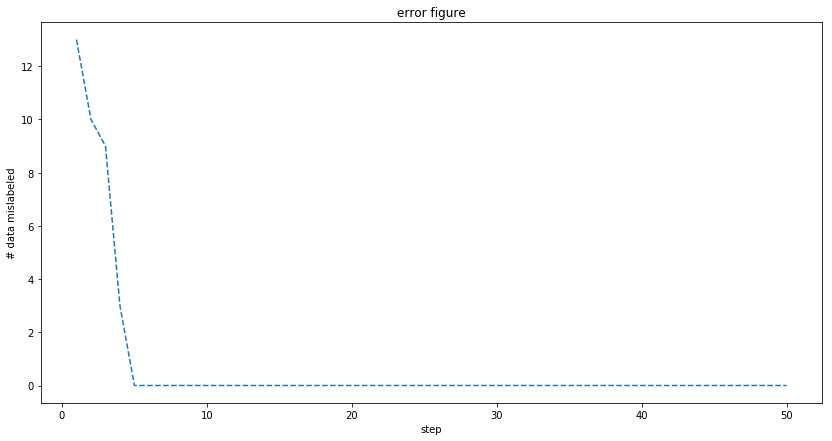

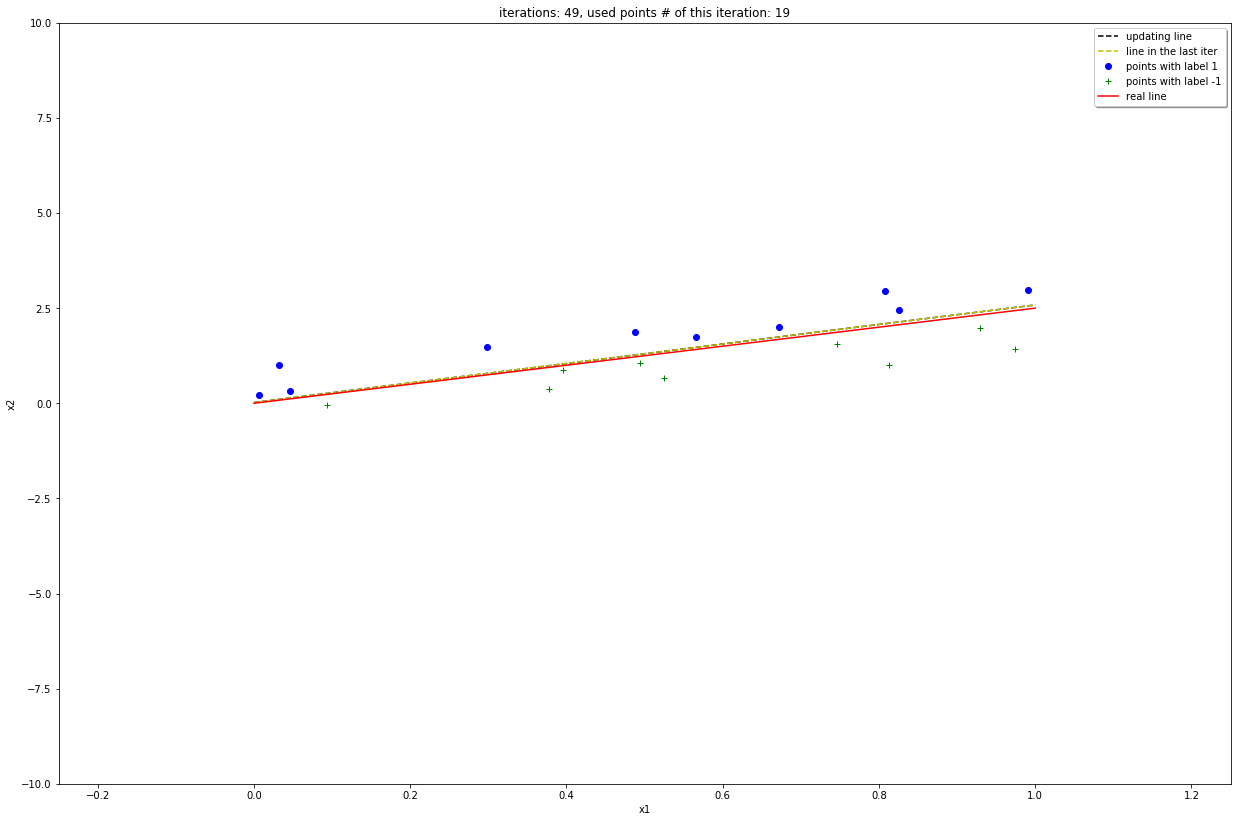

In [302]:
per,m,b=main(eta=0.005,n_iter=50,weight_seed=56,data_seed=99,use_adaptive_stepsize=False,number_of_data_points=20)
ani = SubplotAnimation(per.initplot,per.toplot,m,b)
# ani.save('/tmp/test_sub.mp4')
HTML(ani.to_html5_video())

## Using shuffle & not using

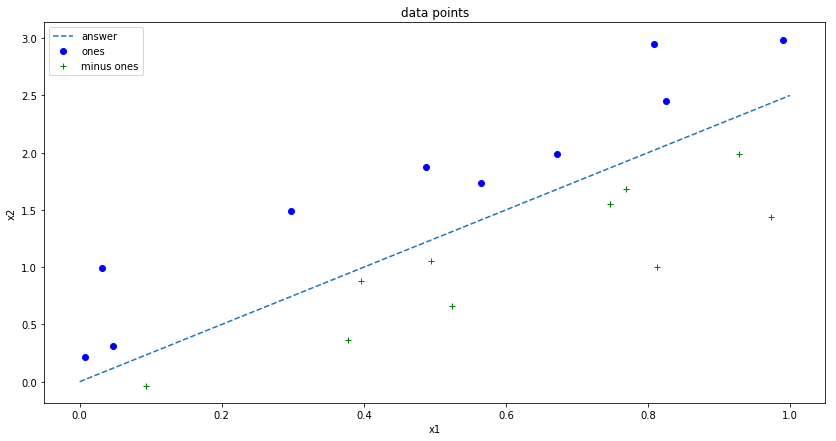

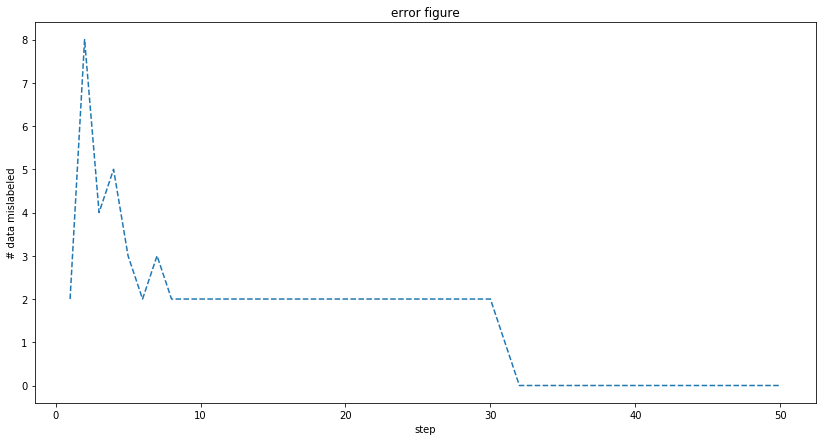

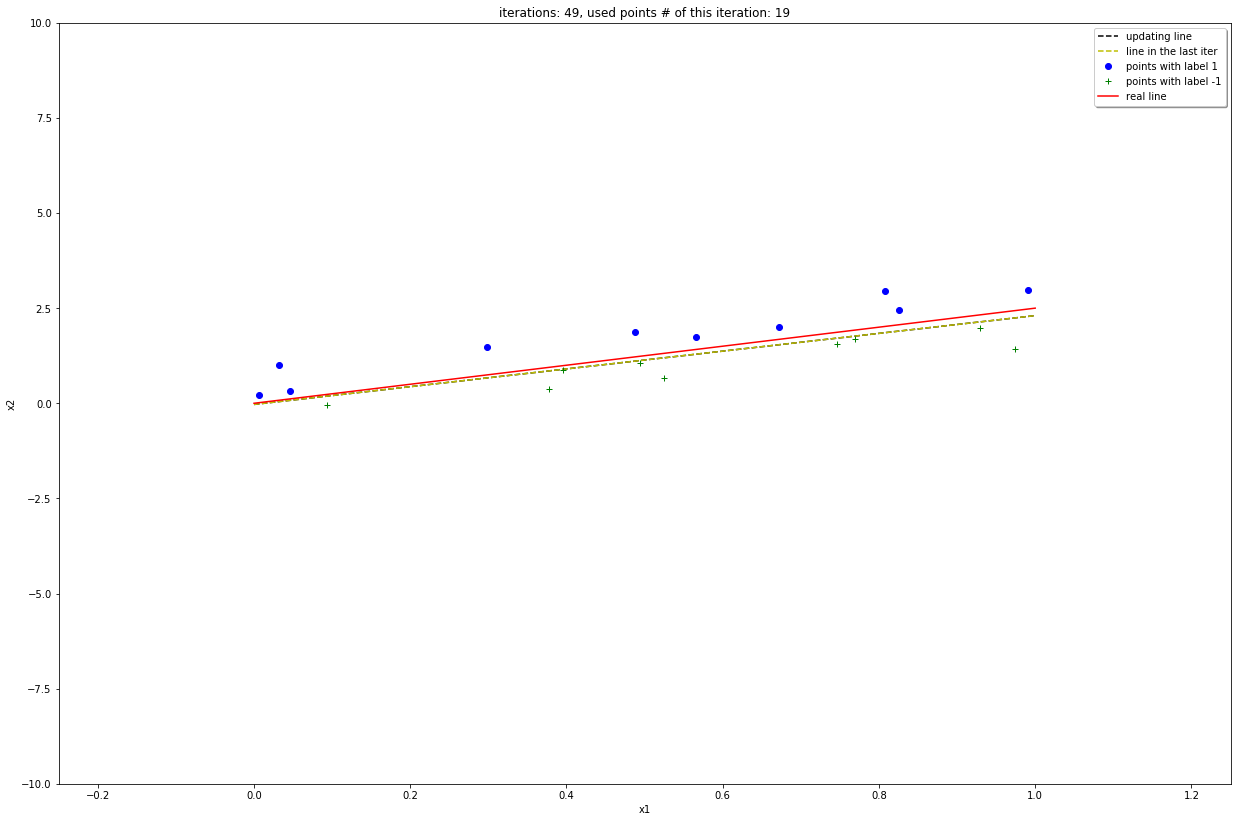

In [305]:
per,m,b=main(eta=0.005,n_iter=50,weight_seed=56,data_seed=99,use_adaptive_stepsize=True,number_of_data_points=20,use_shuffle=False)
ani = SubplotAnimation(per.initplot,per.toplot,m,b)
# ani.save('/tmp/test_sub.mp4')
HTML(ani.to_html5_video())

## Increase the number of points (from 20 to 50)

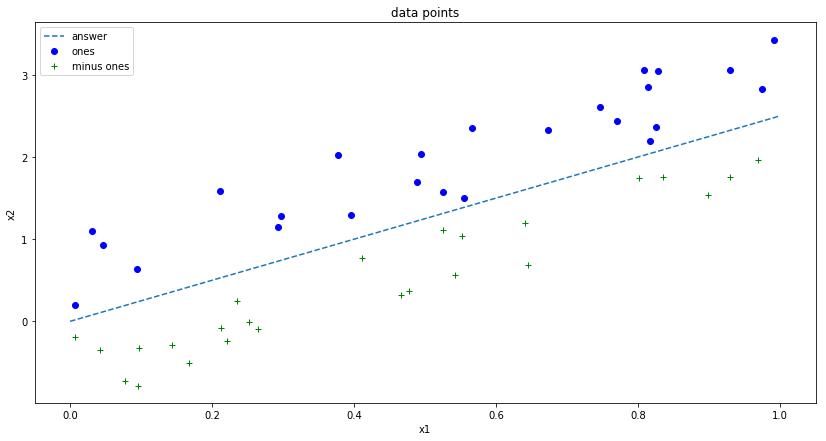

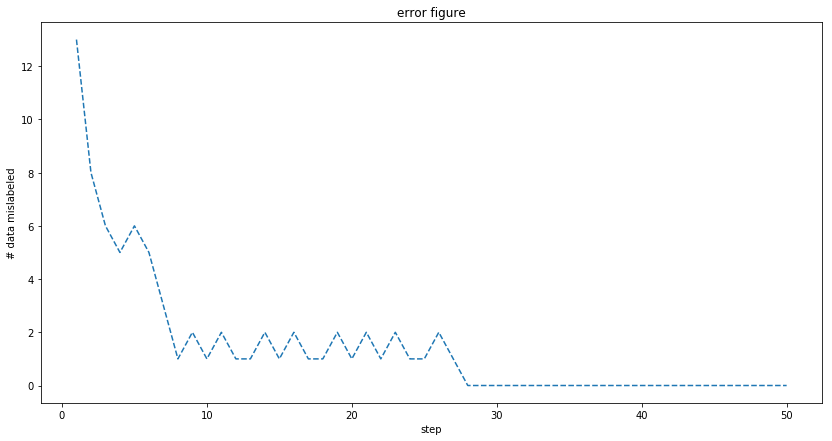

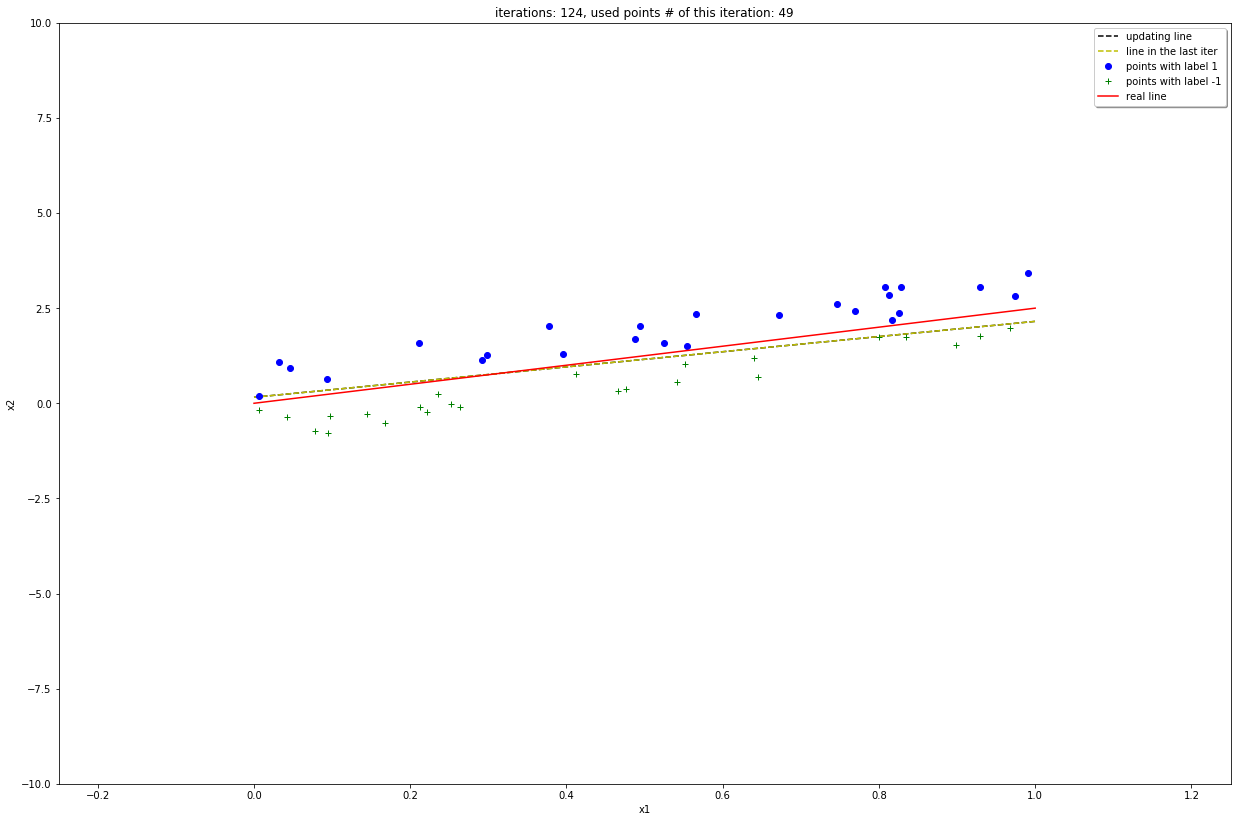

In [307]:
per,m,b=main(eta=0.005,n_iter=50,weight_seed=56,data_seed=99,use_adaptive_stepsize=True,number_of_data_points=50,use_shuffle=True)
ani = SubplotAnimation(per.initplot,per.toplot,m,b)
# ani.save('/tmp/test_sub.mp4')
HTML(ani.to_html5_video())